# Token Count Exploration
It would be really useful for deployment to know our input/output expectations. We know that our output is quite verbose relative to the input since the explanations are long. With a model like `mistralai/Mistral-7B-Instruct-v0.3` Id expect that our real output with explanations will be shorter. Thats perfect since our training data will give us a reliable upper bound, which is great to prevent truncation.

Lets figure out how to split input and output tokens, and then we can build a histogram.

## Config

In [1]:
INPUT_DATASET = 'derek-thomas/labeled-multiple-choice-explained-mistral-tokenized'
BASE_MODEL = 'mistralai/Mistral-7B-Instruct-v0.3'

## Setup

In [2]:
from huggingface_hub import login, get_token
login()

In [3]:
from transformers import AutoTokenizer
from datasets import load_dataset

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, token=get_token())

dataset = load_dataset(INPUT_DATASET, split='train')
df = dataset.to_pandas()

README.md:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/40.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6730 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1683 [00:00<?, ? examples/s]

## Exploration

In [5]:
df['conversation_RFA_sg_gpt3_5'].iloc[0]

'<s>[INST] Answer the Question and include your Reasoning and the Final Answer in a json like: {"Reasoning: "...", "Final Answer": "x"} where x is a letter that corresponds to the answer choice which is a letter between a and h.\nQuestion: What can genetic material have?\nAnswer Choices: (a) Resistance (b) Mutations (c) Clorophyll (d) Nucleotide (e) Symmetry (f) Allow growth (g) Contamination (h) Warmth[/INST] {\'Reasoning\': \'a) Resistance: Genetic material can carry genes that provide resistance to certain diseases or environmental factors, but this is not a characteristic of genetic material itself. Therefore, this option is incorrect.\\n\\nc) Chlorophyll: Chlorophyll is a pigment found in plants that is responsible for photosynthesis. It is not a characteristic of genetic material. Therefore, this option is incorrect.\\n\\nd) Nucleotide: Nucleotides are the building blocks of DNA and RNA, which are types of genetic material. However, this option is too broad and does not fully ans

In [6]:
tokenizer.encode('[/INST]', add_special_tokens=False)

[4]

In [8]:
print(tokenizer.encode(df['conversation_RFA_sg_gpt3_5'].iloc[0], add_special_tokens=False))
tokenizer.encode('[/INST]', add_special_tokens=False)

[1, 3, 27075, 1040, 23246, 1072, 3792, 1342, 2066, 2180, 1056, 1072, 1040, 10990, 27075, 1065, 1032, 8379, 1505, 29515, 10598, 20569, 1056, 29515, 1113, 1869, 1316, 1113, 18268, 27075, 2032, 1113, 29512, 18163, 1738, 2086, 1117, 1032, 6266, 1137, 17303, 1066, 1040, 5140, 5550, 1458, 1117, 1032, 6266, 2212, 1032, 1072, 1063, 29491, 781, 25762, 29515, 2592, 1309, 20637, 4156, 1274, 29572, 781, 3588, 17749, 26173, 1982, 29515, 1093, 29476, 29499, 2760, 5400, 1093, 29494, 29499, 17737, 1465, 1093, 29485, 29499, 2134, 1039, 3894, 20298, 1093, 29483, 29499, 1186, 2253, 1059, 1090, 1315, 1093, 29474, 29499, 13124, 17409, 1093, 29490, 29499, 26780, 6825, 1093, 29489, 29499, 3767, 26682, 1093, 29484, 29499, 1162, 2553, 1130, 4, 12780, 20569, 1056, 2637, 1232, 29476, 29499, 2760, 5400, 29515, 7010, 11130, 4156, 1309, 7864, 24971, 1137, 3852, 13336, 1066, 3320, 19025, 1210, 13275, 9380, 29493, 1330, 1224, 1117, 1227, 1032, 18613, 1070, 20637, 4156, 4605, 29491, 9237, 29493, 1224, 4319, 1117, 1715

[4]

Great, we can see that there is a special token `[/INST]` that we will want to split on. We can count the tokens before and including `[/INST]` and that should be our input tokens, and the tokens after will be our output tokens.

Lets count those for each row in `conversation_RFA` and build a histogram of the results. `conversation_RFA` should be a good max since its just a reshuffle or superset of the other columns.

In [20]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the dataset and convert it to a DataFrame
dataset = load_dataset(INPUT_DATASET, split='test')
df = dataset.to_pandas()

df_token_gpt3_5 = df[['conversation_RFA_sg_gpt3_5']].copy()
df_token_gpt3_5['tokens_gpt3_5'] = df['conversation_RFA_sg_gpt3_5'].apply(lambda x: tokenizer.encode(x))

df_token_mistral = df[['conversation_RFA_sg_mistral']].copy()
df_token_mistral['tokens_mistral'] = df['conversation_RFA_sg_mistral'].apply(lambda x: tokenizer.encode(x))

def split_and_measure(lst):
    if 4 in lst:
        index_of_4 = lst.index(4)
        length_before = index_of_4 + 1  # Including 4
        length_after = len(lst) - length_before
        return length_before, length_after
    else:
        return None, len(lst)  # If 4 is not present

df_token_gpt3_5[['input_tokens', 'output_tokens']] = df_token_gpt3_5['tokens_gpt3_5'].apply(split_and_measure).apply(pd.Series)
df_token_mistral[['input_tokens', 'output_tokens']] = df_token_mistral['tokens_mistral'].apply(split_and_measure).apply(pd.Series)

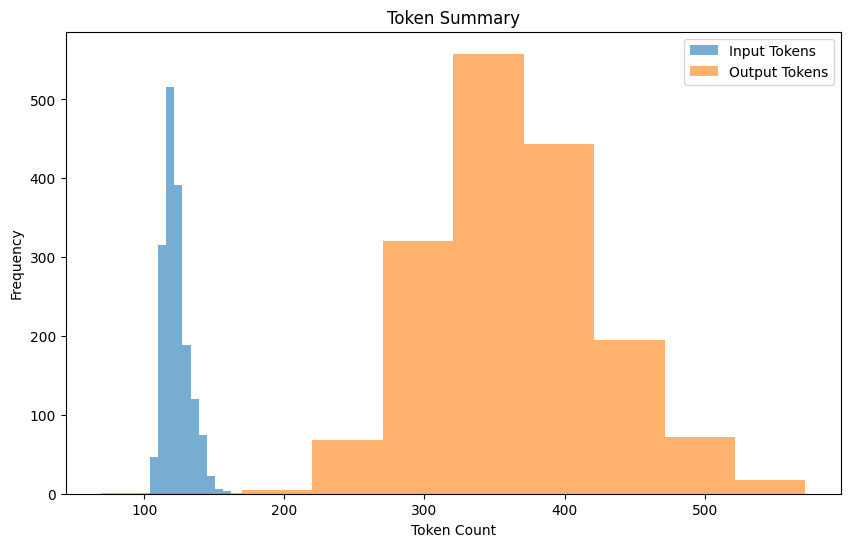

In [22]:
import matplotlib.pyplot as plt

# Plot the histograms
plt.figure(figsize=(10, 6))

# Histogram for Input Tokens
plt.hist(df_token_gpt3_5['input_tokens'], bins=10, alpha=0.6, label='Input Tokens')

# Histogram for Output Tokens
plt.hist(df_token_gpt3_5['output_tokens'], bins=10, alpha=0.6, label='Output Tokens')

# Add titles and labels
plt.title("Token Summary")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.legend()

# Show the plot
plt.show()


In [23]:
print(f"Our Max Input Tokens:\t{max(df_token_gpt3_5.input_tokens)}\nOur Max Output Tokens:\t{max(df_token_gpt3_5.output_tokens)}")

Our Max Input Tokens:	162
Our Max Output Tokens:	572


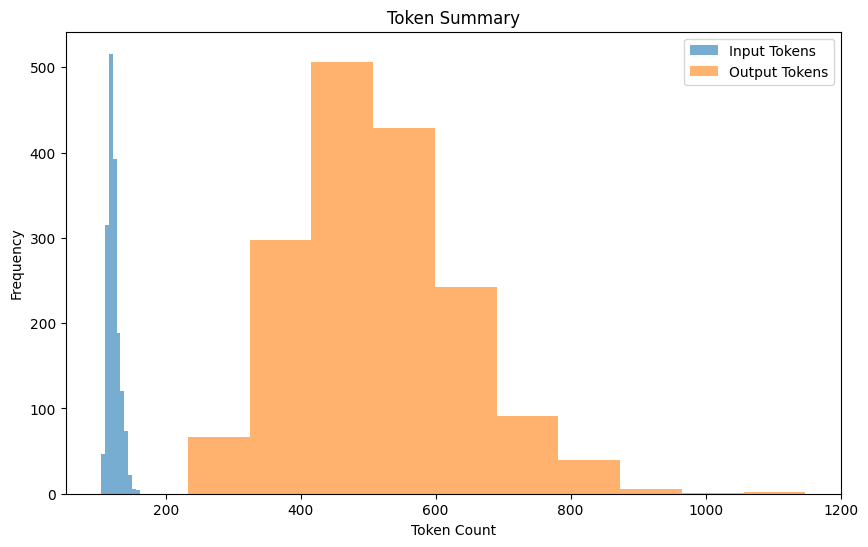

In [24]:
import matplotlib.pyplot as plt

# Plot the histograms
plt.figure(figsize=(10, 6))

# Histogram for Input Tokens
plt.hist(df_token_mistral['input_tokens'], bins=10, alpha=0.6, label='Input Tokens')

# Histogram for Output Tokens
plt.hist(df_token_mistral['output_tokens'], bins=10, alpha=0.6, label='Output Tokens')

# Add titles and labels
plt.title("Token Summary")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.legend()

# Show the plot
plt.show()


In [26]:
print(f"Our Max Input Tokens:\t{max(df_token_mistral.input_tokens)}\nOur Max Output Tokens:\t{max(df_token_mistral.output_tokens)}")

Our Max Input Tokens:	162
Our Max Output Tokens:	1148
